# ตัวอย่างการใช้งาน RetinaNet

เนื่องจาก RetinaNet นั้นมี backbone โมเดลเป็น ResNet50 ซึ่งมีการ pre-trained มาอยู่แล้ว ในตัวอย่างนี้เราจะไม่นำโมเดลมาเทรนใหม่เพราะคงเทรนกันไม่ไหวแน่ๆ
ตัวอย่างนี้จะเน้นไปที่การเรียก RetinaNet ออกมาใช้งานนั่นเอง


ตัวอย่างนี้เป็นโค้ดตัวอย่างที่นำมาจาก git ด้านล่างนี้
[*Keras RetinaNet*](https://github.com/fizyr/keras-retinanet)


โฟลเดอร์ที่เราอยู่นี้เป็นโฟลเดอร์ที่โคลนมาจากลิงก์ด้านบน ภายในนี้จะมีฟังก์ชันต่างๆมากมายที่ผู้พัฒนาได้เตรียมไว้ให้เราเรียบร้อยแล้ว ไม่ว่าจะเป็นการคิด focal loss, สร้าง Feature Pyramid Networks(FPN) หรือแม้กระทั่งตัว detectors


แต่ก่อนอื่นต้องทำการติดตั้ง RetinaNet ให้เรียบร้อยซะก่อนโดยสั่งคำสั่งด้านล่างนี้
- อาจจะมีปัญหาในตอนติดตั้งเพราะว่า c++ build tools นั้นไม่มี ซึ่งสามารถเข้าไปที่ [link](https://visualstudio.microsoft.com/visual-cpp-build-tools/) เพื่อดาวน์โหลดและติดตั้งได้ จากนั้นเลือกติดตั้ง "c++ build tools "
- opencv-python ต้อง version 4.9.0.80
- h5py ต้อง version 3.7

In [4]:
!pip install keras-retinanet/

Processing ./keras-retinanet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached Cython-3.0.11-cp312-cp312-macosx_10_9_x86_64.whl.metadata (3.2 kB)
Using cached Cython-3.0.11-cp312-cp312-macosx_10_9_x86_64.whl (3.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.3 MB/s eta 0:00:00ta 0:00:01
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp312-cp312-macosx_10_15_x86_64.whl size=129719 sha256=e68bcf00c5bdcf9251edf5b44a01102413073675be29d2d7439bab07409ea708
  Stored in directory: /Users/perish/Library/Caches/pip/wheels/c0/54/51/fb9e9e3b393f9da42957978fe3b52a90223d291d74c1164b76
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20456 sha256=716b64abae0b5b81859f7d984e5db20e31cc07d9e36c89ca69b03bbdf7bec584
  Stored in directory: /Users/perish/Library/Caches/pip/wheels/36/74/0c/455526b8e61

In [8]:
import keras
from keras_retinanet.models import load_model
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
gpu = "0"

# set the modified tf session as backend in keras
setup_gpu(gpu)

## load model

โค้ดด้านล่างนี้จะเป็นการโหลดโมเดล Retinanet ที่ pretrain กับ coco dataset ไว้อยู่แล้ว 

In [15]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('keras-retinanet' , 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
custom_objects = models.backbone('resnet50').custom_objects
model = models.load_model(model_path)

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
# model = models.convert_model(model)

# print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

TypeError: 'NoneType' object is not subscriptable

## Run detection on example

ด้านล่างนี้จะเป็นการทำโมเดลที่เราโหลดในเซลด้านบนมาใช้งาน
ผมได้เตรียมไฟล์ที่เป็น .zip ไว้ชื่อว่า archive ให้ทำการแตกไฟล์ให้เรียบร้อยด้านในจะมีโฟลเดอร์อยู่สามอันคือ train, valid, และ test จริงๆแล้ว dataset นี้เป็น coco ที่เป็นเวอร์ชันเล็กเพราะตัวหลักจะมีขนาดไฟล์ใหญ่เกินไป (เกือบ 5GB)

เมื่อแตกไฟล์เป็นที่เรียบร้อยแล้วจะเห็นตัวแปร `folder_dir` ที่จะเป็น path ของไฟล์รูปของเรานั่นเองตอนนี้ผมตั้งไว้ที่ test สามารถแก้ไขตัวแปร `start_img & stop_img` ได้เช่นกันว่าอยากให้นำรูปภาพที่เท่าไหร่ถึงเท่าไหร่บ้างมาผ่าน detector ตัวนี้

ตัวแปร `draw` ในที่นี้เป็นการก็อปปี้รูปภาพที่เราโหลดเข้ามาก่อน จากนั้นจะนำภาพไปผ่าน retinanet ให้เรียบร้อยผลลัพธ์จะออกมาเป็น boxes, scores, และ labels ซึ่งรูปๆหนึ่งสามารถมีผลลัพธ์ได้หลายชุด(พบหลาย obj) จากนั้นจะเอาตัวแปรเหล่านั้นไปเขียน กล่อง และ label ทับ `draw` ที่เราได้เตรียมไว้ก่อนหน้า ท้ายที่สุดแล้วทำการนำมาใส่ subplot ทีละรูปไล่ลงไปเรื่อยและทำการเรียก plt.show()

(800, 1060, 3)
processing time:  0.2894442081451416
(800, 1199, 3)
processing time:  0.1840686798095703
(800, 1067, 3)
processing time:  0.17508149147033691
(1199, 800, 3)
processing time:  0.18709278106689453
(800, 1067, 3)
processing time:  0.17490100860595703
(800, 1199, 3)
processing time:  0.2106616497039795
(800, 1333, 3)
processing time:  0.21732568740844727
(800, 1205, 3)
processing time:  0.21542954444885254
(800, 800, 3)
processing time:  0.13960504531860352
(800, 1067, 3)
processing time:  0.19637656211853027


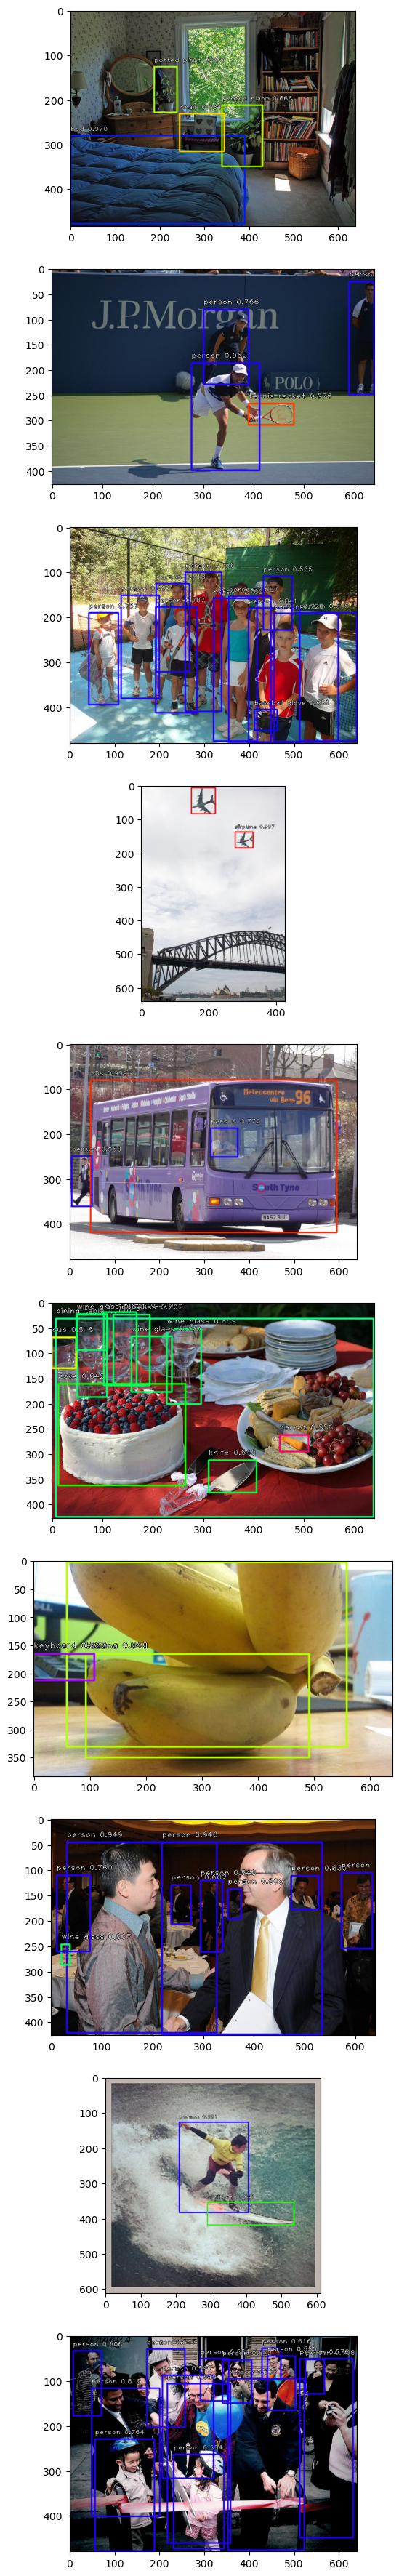

In [28]:
folder_dir = "archive/test/"
start_img = 0
stop_img = 10

plt.figure(figsize=(50,50))

for index, img_name in enumerate(os.listdir(folder_dir)[start_img:stop_img]):
    # check if the image ends with png
    if (img_name.endswith(".jpg")):

        image = read_image_bgr(folder_dir+img_name)
        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        
        # preprocess image for network
        image = preprocess_image(image)
        image, scale = resize_image(image)
        print(image.shape)
        start = time.time()
        boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
        print("processing time: ", time.time() - start)

        # correct for image scale
        boxes /= scale
        
        # visualize detections
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            # scores are sorted so we can break
            if score < 0.5:
                break
                
            color = label_color(label)
            
            b = box.astype(int)
            draw_box(draw, b, color=color)
            
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
        plt.subplot(stop_img-start_img+1,1,index+1)
        plt.imshow(draw)
plt.show()